# Historical vs. Future Magnitudes

Quick look at how seasonal cycle, trend, and residual magnitudes compare betwen 1920--2015 and 2016-2100 to look at effects of climate change

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

import esmtools as et

# Stats
from scipy import stats
import numpy.polynomial.polynomial as poly

In [21]:
EBU = 'BenCS'
VAR = 'FG_CO2'

# Load in Data

In [22]:
def load_in_filtered_data(VAR, EBU, period='historical'):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    # Historical
    if period == 'historical':
        fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    else:
        fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/future_scenario/' + VAR + '/' + EBU + '/filtered_output/'
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [23]:
h_con_mean, h_con_resid, h_con_total = load_in_filtered_data(VAR, EBU, period='historical')
f_con_mean, f_con_resid, f_con_total = load_in_filtered_data(VAR, EBU, period='future')

# Compute each component

In [24]:
def compute_components(con_mean, con_resid, con_total):
    t = con_total['time'].values
    ensemble_mean = con_mean[VAR + '_AW'].values

    # Break down all components
    x = np.arange(0, len(t), 1)
    coefs = poly.polyfit(x, ensemble_mean, 1)
    line_fit = poly.polyval(x, coefs) # This is the trend portion

    # Quantifable trend (first order)
    slope, _, _, _, _ = stats.linregress(x, ensemble_mean)
    slope = slope * len(t)

    # I think the "level" or historical state of the system should clearly
    # not be the mean of the time series due to the trend. You could either
    # just look at the intercept of the linear regression, or the intercept
    # of a 4th order polynomial.
    b = coefs[0]
    level = np.zeros(len(t))
    level[:] = b

    # Seasonal cycle needs to be detrended, but then scaled back up to the intercept
    seasonal_cycle = ensemble_mean 
    
    # COMPUTE COMPONENTS
    mean = con_total[VAR + '_AW'].mean().values.round(2)
    print("Mean: " + str(mean) + ' (mol/m2/yr)')

    print("Intercept: " + str(b.round(2)))

    seasonal = con_mean.apply(et.ufunc.seasonal_magnitude)[VAR + "_AW"].values.round(2)
    print("Seasonal: " + str(seasonal) + ' (mol/m2/yr)')

    internal = con_resid[VAR + '_AW'].std('time').mean('ensemble').values.round(2)
    print("Internal: " + str(internal) + ' (mol/m2/yr)')

    print("Trend: " + str(slope.round(2)) + '(mol/m2/yr/96yr)')
    return line_fit

In [26]:
print("HISTORICAL")
h_line_fit = compute_components(h_con_mean, h_con_resid, h_con_total)
print("\n")
print("FUTURE")
f_line_fit = compute_components(f_con_mean, f_con_resid, f_con_total)


HISTORICAL
Mean: 1.87 (mol/m2/yr)
Intercept: 2.25
Seasonal: 0.77 (mol/m2/yr)
Internal: 0.98 (mol/m2/yr)
Trend: -0.76(mol/m2/yr/96yr)


FUTURE
Mean: -0.04 (mol/m2/yr)
Intercept: 1.27
Seasonal: 0.8 (mol/m2/yr)
Internal: 0.73 (mol/m2/yr)
Trend: -2.62(mol/m2/yr/96yr)


# PLOTS

In [27]:
con_total = xr.concat([h_con_total, f_con_total], dim='time')
con_resid = xr.concat([h_con_resid, f_con_resid], dim='time')
con_mean = xr.concat([h_con_mean, f_con_mean], dim='time')

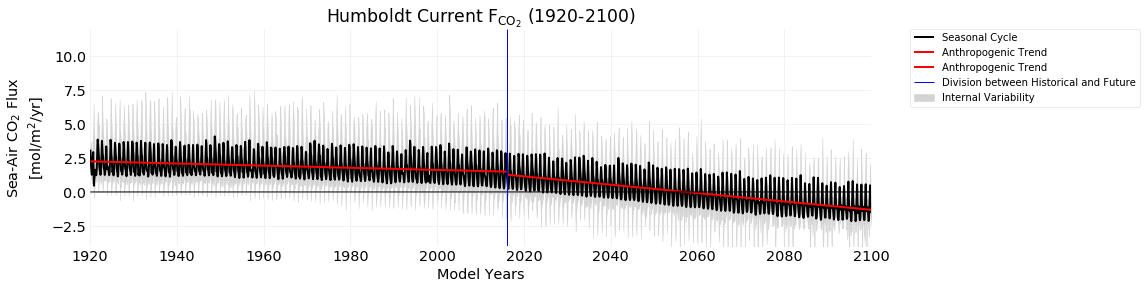

In [28]:
fig = plt.figure(figsize=(14,4))
ax = plt.subplot(111)

# Some terms
t = con_total['time'].values
ensemble_mean = con_mean[VAR + '_AW'].values
seasonal_cycle = ensemble_mean
x = np.arange(0, len(t), 1)
coefs = poly.polyfit(x, ensemble_mean, 1)
line_fit = poly.polyval(x, coefs) # This is the trend portion

# RESIDUALS
#for idx in np.arange(0, 34, 1):
#    data = con_total['FG_CO2_AW'][:, idx].values
#    plt.plot(t, data, color='#d3d3d3', linewidth=1)

# This approach makes it easier to work with in Illustrator.
data_min = con_total[VAR + "_AW"].max('ensemble')
data_max = con_total[VAR + "_AW"].min('ensemble')
plt.fill_between(t, data_min, data_max, color='#d3d3d3', label='Internal Variability')

# SEASONALITY
plt.plot(t, seasonal_cycle, linewidth=2, color='k', label='Seasonal Cycle')

# TREND
plt.plot(t[0:1152], h_line_fit, color='r', linewidth=2, label='Anthropogenic Trend')
plt.plot(t[1152:], f_line_fit, color='r', linewidth=2, label='Anthropogenic Trend')


# LEVEL
#plt.plot(t, level, color='k', linewidth=2, linestyle='--')

# Zero line    
plt.plot(t, np.zeros(len(t)), color='k', linewidth=1)
ax.set(xlim=['1920', '2100'])

ax.set(ylim=[-4, 12])

# Aesthetics
ax.set_title('Humboldt Current F$_{\mathrm{CO}_{2}}$ (1920-2100)')
ax.set_xlabel('Model Years')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux' + '\n' +  '[mol/m$^{2}$/yr]')

plt.plot([t[1151], t[1151]], [-4, 12], color='b', linewidth=1, label='Division between Historical and Future')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save figure.
#et.vis.savefig('humboldt_full_time', extension='.eps', dpi=300)